In [729]:
import os
import torch
import os
import torchvision.models as models
import torch.nn as nn
from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
from deepface import DeepFace
import torch.nn as nn
import torch.nn.functional as F


In [730]:
# GLOBAL VARS
training_size = None
epochs = 2
batch_size = 16
lr_faces = 0.001
lr_scene = 0.001
lr_model = 0.01

clean_df = False
max_faces = 3

In [731]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog


In [732]:
# try to read all the images to see if any are missing or corrupted
if clean_df:
    df = pd.read_csv(os.path.join(findingemo_dir, "annotations_single.ann"))

    # Delete the columns: "user" and "index" and "datetime"
    if "user" in df.columns and "index" in df.columns and "datetime" in df.columns:
        df = df.drop(columns=["user", "index", "datetime"])

    # remove leading slash from image_path
    if df["image_path"].iloc[0].startswith("/"):
        df["image_path"] = df["image_path"].str.lstrip("/")

    # in the dataframe image_path column, change all the occurences of 'lmertens' to 'anon'
    df["image_path"] = df["image_path"].str.replace("lmertens", "anon", regex=False)
    # change the occurences of *, : ? in the image_path to _
    df["image_path"] = df["image_path"].str.replace("*", "_", regex=False)
    df["image_path"] = df["image_path"].str.replace(":", "_", regex=False)
    df["image_path"] = df["image_path"].str.replace("?", "_", regex=False)
    
    corrupted_indices = []
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Checking image {idx}/{len(df)}")
        img_path = os.path.join(findingemo_dir, row['image_path'])
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Image at index {idx} could not be read: {img_path}")
                corrupted_indices.append(idx)
        except Exception as e:
            print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
    print(f"Total corrupted/missing images: {len(corrupted_indices)}")
    print("Corrupted indices:", corrupted_indices)
    # Remove corrupted entries from dataframe
    df = df.drop(index=corrupted_indices).reset_index(drop=True)
    # save the cleaned dataframe as pickle
    df.to_pickle("clean_findingemo.pkl")

else:
    df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))

In [733]:
# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)

In [734]:
# set device, move models and maps, set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [735]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [736]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]

In [737]:
scene_categories

['airfield',
 'airplane_cabin',
 'airport_terminal',
 'alcove',
 'alley',
 'amphitheater',
 'amusement_arcade',
 'amusement_park',
 'apartment_building_outdoor',
 'aquarium',
 'aqueduct',
 'arcade',
 'arch',
 'archaelogical_excavation',
 'archive',
 'arena_hockey',
 'arena_performance',
 'arena_rodeo',
 'army_base',
 'art_gallery',
 'art_school',
 'art_studio',
 'artists_loft',
 'assembly_line',
 'athletic_field_outdoor',
 'atrium_public',
 'attic',
 'auditorium',
 'auto_factory',
 'auto_showroom',
 'badlands',
 'bakery_shop',
 'balcony_exterior',
 'balcony_interior',
 'ball_pit',
 'ballroom',
 'bamboo_forest',
 'bank_vault',
 'banquet_hall',
 'bar',
 'barn',
 'barndoor',
 'baseball_field',
 'basement',
 'basketball_court_indoor',
 'bathroom',
 'bazaar_indoor',
 'bazaar_outdoor',
 'beach',
 'beach_house',
 'beauty_salon',
 'bedchamber',
 'bedroom',
 'beer_garden',
 'beer_hall',
 'berth',
 'biology_laboratory',
 'boardwalk',
 'boat_deck',
 'boathouse',
 'bookstore',
 'booth_indoor',
 'b

In [738]:
# read the csv file from the data folder
categories_365_path = os.path.join(data_dir, "CategoriesPlaces365.xlsx")

# read as csv
categories_365_df = pd.read_excel(categories_365_path)

In [739]:
categories_365_df.head()

,commercial,summer,sport,playful,royal,relaxing,house_interior,food,cold,scary,transport,work,nature,horeca,agriculture,depressing,industrial,urban,cultural,woods
0,bakery_shop,harbor,arena_hockey,nursery,banquet_hall,jacuzzi_indoor,living_room,pantry,crevasse,attic,airfield,home_office,viaduct,bar,vegetable_garden,hospital,assembly_line,building_facade,church_outdoor,hunting_lodge_outdoor
1,butchers_shop,berth,arena_performance,playroom,ballroom,bedroom,kitchen,dining_room,mountain_snowy,basement,airplane_cabin,bank_vault,dam,pub_indoor,wheat_field,hospital_room,auto_factory,downtown,mosque_outdoor,cottage
2,clothing_store,coast,arena_rodeo,childs_room,bedchamber,bathroom,closet,fastfood_restaurant,ice_floe,alley,airport_terminal,server_room,badlands,cafeteria,wind_farm,jail_cell,engine_room,street,synagogue_outdoor,tree_house
3,department_store,grotto,baseball_field,candy_store,auto_showroom,television_room,dorm_room,restaurant,ice_shelf,catacomb,railroad_track,auditorium,canyon,coffee_shop,barn,army_base,industrial_area,shopfront,temple_asia,inn_outdoor
4,jewelry_shop,islet,basketball_court_indoor,florist_shop_indoor,church_indoor,shower,hotel_room,restaurant_kitchen,iceberg,NaN,train_interior,classroom,cliff,pub_indoor,farm,trench,oilrig,parking_lot,mausoleum,NaN


In [740]:
# From the dataframe, create a dictionary that maps every category to its broader category (column where it belongs)
category_mapping = {}
for col in categories_365_df.columns:
    for category in categories_365_df[col].dropna().tolist():
        category_mapping[category] = col

In [741]:
mapped_categories = sorted(list(dict.fromkeys(category_mapping.values())))
print("Mapped Categories:", mapped_categories)

Mapped Categories: ['agriculture', 'cold', 'commercial', 'cultural', 'depressing', 'food', 'horeca', 'house_interior', 'industrial', 'nature', 'playful', 'relaxing', 'royal', 'scary', 'sport', 'summer', 'transport', 'urban', 'woods', 'work']


In [742]:
# Check if all the 365 categories are in the mapping
for cat in scene_categories:
    if cat not in category_mapping:
        print("Category not found in mapping:", cat)

In [743]:
# check if all keys in category_mapping are in scene_categories
for cat in category_mapping.keys():
    if cat not in scene_categories:
        print("Category in mapping not found in scene categories:", cat)

In [744]:
len(category_mapping)

365

In [745]:
finding_emo_labels = sorted(df["emotion"].unique().tolist())
print(finding_emo_labels)

['Acceptance', 'Admiration', 'Amazement', 'Anger', 'Annoyance', 'Anticipation', 'Apprehension', 'Boredom', 'Disgust', 'Distraction', 'Ecstasy', 'Fear', 'Grief', 'Interest', 'Joy', 'Loathing', 'Pensiveness', 'Rage', 'Sadness', 'Serenity', 'Surprise', 'Terror', 'Trust', 'Vigilance']


In [746]:
# Build mapping matrix with deterministic column order and float dtype
map_365 = torch.zeros((365, len(mapped_categories)), dtype=torch.float32)
for i, cat in enumerate(scene_categories):
    coarse = category_mapping[cat]
    coarse_idx = mapped_categories.index(coarse)
    map_365[i, coarse_idx] = 1.0

In [747]:
def get_mapped_category(scene_idx_365):
    # print the name of the 365 category
    mapped = map_365[scene_idx_365]
    mapped_idx = torch.argmax(mapped).item()
    print(scene_categories[scene_idx_365], "->", mapped_categories[mapped_idx])

In [748]:
for i in range(len(scene_categories)):
    get_mapped_category(i)

airfield -> transport
airplane_cabin -> transport
airport_terminal -> transport
alcove -> house_interior
alley -> scary
amphitheater -> cultural
amusement_arcade -> playful
amusement_park -> playful
apartment_building_outdoor -> urban
aquarium -> cultural
aqueduct -> nature
arcade -> playful
arch -> cultural
archaelogical_excavation -> cultural
archive -> cultural
arena_hockey -> sport
arena_performance -> sport
arena_rodeo -> sport
army_base -> depressing
art_gallery -> cultural
art_school -> work
art_studio -> cultural
artists_loft -> house_interior
assembly_line -> industrial
athletic_field_outdoor -> sport
atrium_public -> work
attic -> scary
auditorium -> work
auto_factory -> industrial
auto_showroom -> royal
badlands -> nature
bakery_shop -> commercial
balcony_exterior -> urban
balcony_interior -> house_interior
ball_pit -> playful
ballroom -> royal
bamboo_forest -> nature
bank_vault -> work
banquet_hall -> royal
bar -> horeca
barn -> agriculture
barndoor -> house_interior
baseba

In [ ]:
# Now create train/test splits with clean data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)
print("Training set shape: ",df_train.shape)
print("Test set shape: ",df_test.shape)

Training set shape:  (20693, 8)
Test set shape:  (5174, 8)


In [750]:
df_train.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Appreciative students fighting/625d946ec...,Undefined,"Young Adults,Adults",3,0,Ecstasy,"BodyLanguage,Context,FacialExpression,Staging",0
1,Run_2/Heated people desert/291BE5FB00000578-0-...,Undefined,Seniors,-1,4,Serenity,"BodyLanguage,Context",1
2,Run_2/Heated people home/19356100.jpg,Undefined,"Children,Youth",0,1,Serenity,BodyLanguage,1
3,Run_2/Content elderly tennis/montreal-que-apri...,Undefined,"Children,Youth,Young Adults,Adults,Seniors",3,4,Ecstasy,"Context,FacialExpression,Staging",4
4,Run_2/Pain teenagers rally/GF36ZVIIE5RV4RXMLC6...,Undefined,"Adults,Seniors",0,0,Admiration,Neutral,0


In [751]:
def show_image(dataframe, index):
    img_path = os.path.join(findingemo_dir, dataframe.loc[index, 'image_path'])
    print("Image path:", img_path)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Image path: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\Run_2/Pain teenagers rally/GF36ZVIIE5RV4RXMLC6PVLBU5Q.jpg


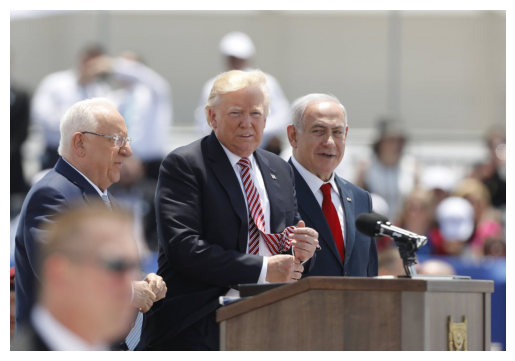

In [752]:
show_image(df_train, 4)

In [753]:
def show_deepface_represent(index, df):
    img_path = os.path.join(findingemo_dir, df.loc[index, 'image_path'])
    print("Image path:", img_path)
    embedding = DeepFace.represent(img_path, detector_backend='retinaface', enforce_detection=False)
    print("Embedding shape:", np.array(embedding).shape)
    print("Embedding:", embedding)
    return embedding

In [754]:
embedding = show_deepface_represent(4, df_train)

Image path: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\Run_2/Pain teenagers rally/GF36ZVIIE5RV4RXMLC6PVLBU5Q.jpg
Embedding shape: (4,)
Embedding: [{'embedding': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00207375726151123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005560215762871957, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03775412652934648, 0.0, 0.0, 0.0, 0.0, 0.0035319313290606506, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008232107594473478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09321908777377788, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03518313232008257, 0.0, 0.0, 0.0, 0.0, 0.07723346536541034, 0.0, 0.0, 0.10803958673106998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.975604189309208e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054653125779284294, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09271380694011672, 0.0,

In [755]:
def show_deepface_analyze(index, df):
    img_path = os.path.join(findingemo_dir, df.loc[index, 'image_path'])
    objs = DeepFace.analyze(img_path, actions = ['emotion'], enforce_detection=False, detector_backend = 'retinaface')
    # Load image (ensure it's in RGB)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create a figure with subplots (1 row per face)
    n_faces = len(objs)
    fig, axes = plt.subplots(n_faces, 2, figsize=(5, 2 * n_faces))

    if n_faces == 1:
        axes = np.expand_dims(axes, axis=0)  # Handle single face case

    for i, face_obj in enumerate(objs):
        region = face_obj["region"]
        x, y, w, h = region["x"], region["y"], region["w"], region["h"]
        face_crop = img[y:y+h, x:x+w]

        # -------- FACE PANEL --------
        dom_emotion = face_obj.get("dominant_emotion", "?")

        title = f"Face {i+1} | {dom_emotion}"
        axes[i, 0].imshow(face_crop)
        axes[i, 0].set_title(title, fontsize=11)
        axes[i, 0].axis("off")

        # -------- EMOTION DISTRIBUTION --------
        emotions = face_obj["emotion"]
        labels_e = list(emotions.keys())
        values_e = np.array(list(emotions.values()))
        values_e = 100 * values_e / np.sum(values_e)
        axes[i, 1].barh(labels_e, values_e, color="skyblue")
        axes[i, 1].invert_yaxis()
        axes[i, 1].set_xlim(0, 100)
        axes[i, 1].set_title("Emotion (%)")

    plt.tight_layout()
    plt.show()


In [756]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model.load_state_dict(state_dict)

print("Loaded pretrained models")

Loaded pretrained models


In [ ]:
scene_model.to(device)
scene_model.train()
print("Moved models to device and set to eval mode")

Moved models to device and set to eval mode


In [758]:
# # Freeze ResNet backbone, keep fc trainable
# for param in scene_model.parameters():
#     param.requires_grad = False

In [759]:
# get different emotions and the length of the different emotions
emotions = df['emotion'].unique().tolist()
print("Emotions:", emotions)
num_emotions = len(emotions)
print("Number of emotions:", num_emotions)

Emotions: ['Trust', 'Interest', 'Apprehension', 'Anticipation', 'Anger', 'Joy', 'Fear', 'Grief', 'Serenity', 'Vigilance', 'Boredom', 'Ecstasy', 'Admiration', 'Acceptance', 'Sadness', 'Rage', 'Annoyance', 'Terror', 'Amazement', 'Surprise', 'Pensiveness', 'Loathing', 'Distraction', 'Disgust']
Number of emotions: 24


In [760]:
class FaceEmotionAdapter(nn.Module):
    def __init__(self, in_dim=4096, hidden_dim=256, out_dim=24):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.out_dim = out_dim

    def forward(self, x):
        # Convert to tensor if it's a list
        if isinstance(x, list):
            x = torch.stack([torch.tensor(item, dtype=torch.float32) if not isinstance(item, torch.Tensor) else item for item in x])
        elif not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)

        # Ensure x is on the right device
        x = x.to(next(self.parameters()).device)
        
        # detect dummy embeddings (sum of abs values == 0)
        mask = (x.abs().sum(dim=1) == 0).unsqueeze(1)  # Shape: (batch, 1)
        
        h = F.relu(self.fc1(x))
        probs = F.softmax(self.fc2(h), dim=1)
        
        # create uniform distribution for dummy rows
        uniform = torch.ones_like(probs) / self.out_dim
        
        # Use torch.where instead of in-place assignment
        probs = torch.where(mask, uniform, probs)
        
        return probs
    
face_emotion_adapter = FaceEmotionAdapter()
face_emotion_adapter.to(device)
face_emotion_adapter.train()
face_emotion_adapter_network = Network(face_emotion_adapter, "face_model", batching=True)
face_emotion_adapter_network.optimizer = torch.optim.Adam(face_emotion_adapter.parameters(), lr=lr_faces)

In [761]:
class MappedSceneModel(nn.Module):
    def __init__(self, model, map_365 = map_365):
        super().__init__()
        self.model = model
        self.register_buffer("map_365", map_365.clone().float())

    def forward(self, x):
        device = next(self.model.parameters()).device
        x = x.to(device)
        logits_365 = self.model(x)
        probs_365 = torch.softmax(logits_365, dim=1)
        mapped_probs = torch.matmul(probs_365, self.map_365)
        return mapped_probs
    
mapped_scene_model = MappedSceneModel(scene_model)
mapped_scene_model.to(device)
scene_network = Network(mapped_scene_model, "scene_model", batching = True)
scene_network.optimizer = torch.optim.Adam(mapped_scene_model.parameters(), lr=lr_scene)

In [762]:
def display_tensor_as_image(tensor):
    tensor = tensor.squeeze(0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    array = tensor.permute(1, 2, 0).numpy()
    plt.imshow(array)
    plt.axis('off')
    plt.show()

In [763]:
if training_size is not None:
    df_train = df_train[:training_size]

In [764]:
class Scene(object):
    def __init__(self, dataframe, subset):
        self.subset = subset
        self.dataframe = dataframe

    def __getitem__(self, i):
        index = int(i[0]) if isinstance(i, (tuple, list)) else int(i)
        img_path = os.path.join(findingemo_dir, self.dataframe.loc[index, 'image_path'])
        image = Image.open(img_path).convert('RGB')
        return scene_processor(image)

In [765]:
scene_train = Scene(df_train, "train")
scene_test = Scene(df_test, "test")

In [766]:
class Faces(object):
    def __init__(self, df):
        self.df = df
        self._last_sample_id = None
        self._last_embeddings = None
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        # Handle tuple input from DeepProbLog
        if isinstance(i, tuple):
            # Extract integer values from Constant terms if necessary
            sample_id = int(i[0]) if not isinstance(i[0], int) else i[0]
            face_id = int(i[1]) if not isinstance(i[1], int) else i[1]
        # Check if we need to compute embeddings for a new image
        if sample_id != self._last_sample_id:
            img_path = os.path.join(findingemo_dir, self.df.loc[sample_id, 'image_path'])
            represent = DeepFace.represent(img_path, detector_backend='retinaface', enforce_detection=False)
            # Sort by facial area size (largest first)
            facial_area_sizes = [x['facial_area']['w'] * x['facial_area']['h'] for x in represent]
            sorted_indices = np.argsort(facial_area_sizes)[::-1]
            
            # Extract sorted embeddings, limit to max_faces
            self._last_embeddings = [np.array(represent[i]['embedding']) for i in sorted_indices[:max_faces]]
            self._last_sample_id = sample_id
            
        # Return the requested face or zero embedding
        if face_id >= len(self._last_embeddings):
            return np.zeros((4096,))
        
        return self._last_embeddings[face_id]

In [767]:
faces_train = Faces(df_train)
faces_test = Faces(df_test)

In [768]:
x = faces_train[(40,0)]
x.shape

(4096,)

In [769]:
# pass the tensor through the face_emotion_adapter
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
probs = face_emotion_adapter(x_tensor)
print(probs)

tensor([[0.0395, 0.0425, 0.0409, 0.0400, 0.0399, 0.0397, 0.0407, 0.0438, 0.0425,
         0.0402, 0.0391, 0.0430, 0.0425, 0.0440, 0.0439, 0.0436, 0.0436, 0.0418,
         0.0412, 0.0429, 0.0435, 0.0404, 0.0413, 0.0393]], device='cuda:0',
       grad_fn=<WhereBackward0>)


In [770]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [771]:
class FindingEmoDataset(Dataset):
    def __init__(self, dataframe, subset):
        super(FindingEmoDataset, self).__init__()
        self.dataframe = dataframe
        self.subset = subset

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        return item
        
    def to_query(self, i):
        # Suppose valence ∈ [-3, 3]
        valence = float(self.dataframe.loc[i, "valence"])
        valence = (valence + 3) / 6   # normalize to [0, 1]

        # Likewise for arousal
        arousal = float(self.dataframe.loc[i, "arousal"])
        arousal = arousal / 6

        sub_embeddings = [Term(f"face_{x}") for x in range(max_faces)]
        embeddings = [
            Term("tensor", Term(f"{self.subset}_faces", Constant(i), Constant(x)))
            for x in range(max_faces)
        ]

        sub = {sub_embeddings[x]: embeddings[x] for x in range(max_faces)}

        queries = [
            Query(
                query=Term("final_valence",
                        list2term(sub_embeddings),
                        Term("tensor", Term(f"{self.subset}_scene", Constant(i))),
                        Var("Valence")),
                p=valence,
                substitution=sub
                ),
            Query(
                query=Term("final_arousal",
                        list2term(sub_embeddings),
                        Term("tensor", Term(f"{self.subset}_scene", Constant(i))),
                        Var("Arousal")),
                p=arousal,
                substitution=sub
                )
        ]
        return queries

In [772]:
def make_query_dataset(df, subset):
    base = FindingEmoDataset(df, subset)
    all_queries = []
    for i in range(len(base)):
        all_queries.extend(base.to_query(i))

    return QueryDataset(all_queries)

In [773]:
train_dataset = make_query_dataset(df_train, "train")
test_dataset = make_query_dataset(df_test, "test")

In [774]:
print(train_dataset.to_query(22))

(0.6666666666666666::final_valence([face_0, face_1, face_2],tensor(train_scene(11)),Valence), {face_0: tensor(train_faces(11,0)), face_1: tensor(train_faces(11,1)), face_2: tensor(train_faces(11,2))})


In [775]:
loader = DataLoader(train_dataset, batch_size)

In [776]:
model = Model(
    os.path.join(prolog_dir, "model4.pl"),
    [scene_network, face_emotion_adapter_network]
)
model.set_engine(ExactEngine(model), cache=False)
model.optimizer = SGD(model, param_lr=lr_model)

model.add_tensor_source("train_faces", faces_train)
model.add_tensor_source("train_scene", scene_train)
model.add_tensor_source("test_faces", faces_test)
model.add_tensor_source("test_scene", scene_test)

In [777]:
train_obj = train_model(
    model,
    loader,
    epochs,
    loss_function_name="mse",
    log_iter= 100
    # test_iter=5 * len(test_dataset) // batch_size,
    # test=lambda x: [
    #     ("Accuracy", get_confusion_matrix(model, test_dataset).accuracy())
    # ],
)  # ,
# Cm based on max prediction
# cm = get_confusion_matrix(model, test_dataset)

Training  for 2 epoch(s)
Epoch 1
Iteration:  100 	s:5.4794 	Average Loss:  0.35296874999999994
0.24155573687287393	0.1985182328773232	0.5599260302498028
Iteration:  200 	s:6.7222 	Average Loss:  0.3675694444444445
0.24155573687287393	0.1985182328773232	0.5599260302498028
Iteration:  300 	s:6.1888 	Average Loss:  0.3507118055555555
0.24155573687287393	0.1985182328773232	0.5599260302498028
Iteration:  400 	s:5.5017 	Average Loss:  0.3708506944444446
0.24155573687287393	0.1985182328773232	0.5599260302498028
Iteration:  500 	s:6.0090 	Average Loss:  0.35472222222222227
0.24155573687287393	0.1985182328773232	0.5599260302498028
Iteration:  600 	s:6.9587 	Average Loss:  0.35536458333333326
0.24155573687287393	0.1985182328773232	0.5599260302498028
Iteration:  700 	s:6.9929 	Average Loss:  0.35262152777777783
0.24155573687287393	0.1985182328773232	0.5599260302498028
Iteration:  800 	s:6.5624 	Average Loss:  0.35026041666666674
0.24155573687287393	0.1985182328773232	0.5599260302498028
Iteration:

In [778]:
# save the model under model directory
model_directory = os.path.join(base_dir, "code", "models")

dpl_state_path = os.path.join(model_directory, "deepproblog_state.pth")
model.save_state(dpl_state_path)

In [779]:
# prolog_path = os.path.join(prolog_dir, "model4.pl")
# model = Model(prolog_path, [scene_network, face_emotion_adapter_network])
# model.set_engine(ExactEngine(model), cache=False)

# dpl_state_path = os.path.join(model_directory, "deepproblog_state.pth")
# model.load_state(dpl_state_path)

# # Ready for inference or continued training
# model.add_tensor_source("train_faces", faces_train)
# model.add_tensor_source("train_scene", scene_train)
# model.add_tensor_source("test_faces", faces_test)
# model.add_tensor_source("test_scene", scene_test)

# face_emotion_adapter.eval()
# mapped_scene_model.eval()

In [780]:
# cf = get_confusion_matrix(model, test_dataset)